In [1]:
import numpy as np
from matplotlib import pyplot as plt
import decimal
from scipy import signal
%matplotlib inline

# Generating

In [2]:
def square(x):
    x = np.sin(x)
    return np.where(x >= 0, 1, -1).astype(float)

def generate_data(func, noise=0):
    X = np.arange(0, 2*np.pi, 0.01).reshape(-1,1)
    Y = func(2*X)

    clean_X = X[5::10].copy()
    clean_Y = Y[5::10].copy()

    if noise > 0:
        Y += np.random.normal(0, noise_std, Y.shape)

    train_X = X[::10].copy()
    train_Y = Y[::10].copy()

    test_X = X[5::10].copy()
    test_Y = Y[5::10].copy()

    return train_X, train_Y, test_X, test_Y, clean_X, clean_Y


[[0. ]
 [0.1]
 [0.2]
 [0.3]]
[[0.05]
 [0.15]
 [0.25]
 [0.35]]


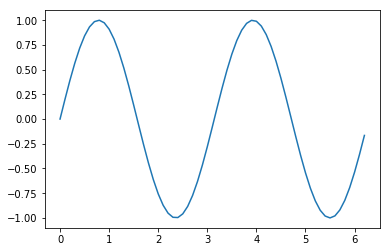

In [3]:
np.random.seed(12)
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(np.sin)
print(train_X[:4])
print(test_X[:4])
plt.plot(train_X,train_Y)

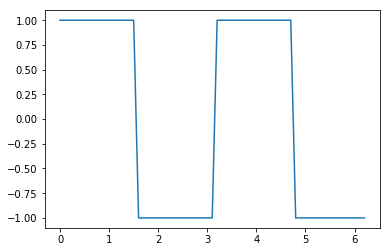

In [4]:
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(square)
plt.plot(train_X,train_Y)

# RBFs

In [156]:
def evenly_spaced_rbf(count):
    centers = []
    for i in range(count):
        centers.append(i*2*np.pi/(count))
    centers = np.reshape(np.array(centers), (len(centers),1))
    return centers

#only works with even numbers why not
def unevenly_spaced_rbf(count):
    centers= []
    A = list(range(count))
    B = A[:len(A)//2]
    C = A[len(A)//2:]
    
    for i in B:
        centers.append(i*2*np.pi/(count*2))
    
    for i in C:
        centers.append(i*2*np.pi/(count))
        
    return centers

def custom_rbf():
    return np.array([[   ]]) #put stuff here

In [26]:
evenly_spaced_rbf(3)

array([[0.       ],
       [2.0943951],
       [4.1887902]])

# Network

In [151]:
class RBF():
    def __init__(self, centers, sigma=0.1, use_batch=True):
        self.sigma = sigma
        self.centers = centers
        self.use_batch = use_batch
        self.weights = None
        
    def RBF(self, x, mu, sigma):
        return np.exp((-(np.linalg.norm(x-mu))**2)/(2*sigma**2))
    
    def get_phi(self, X):
        N = len(X)
        n = len(self.centers)
        phi = np.zeros((N,n))
        
        for i in range(N):
            for j in range(n):
                phi[i,j] = self.RBF(X[i,:], self.centers[j,:], self.sigma)
                
        return phi
    
    def predict(self,X):
        phi = self.get_phi(X)
        return phi.dot(self.weights)
    
    def shuffle(self, X, Y):
        n = X.shape[0]
        n_X = np.zeros((n,1))
        n_Y = np.zeros((n,1))
        
        idx = np.random.permutation(n)
        for i in idx:
            n_X[i][0] = X[idx[i]][0]
            n_Y[i][0] = Y[idx[i]][0]
        
        return n_X, n_Y
    
    def calculate_error_ABS(self, X, Y):
        predictions = self.predict(X)
        return np.mean(np.abs(Y-predictions))
    
    def calculate_error_MSE(self, X, Y):
        predictions = self.predict(X)
        return np.mean(np.square(Y-predictions))
    
    def train(self, train_X, train_Y, test_X, test_Y, n_epochs, eta = 0.3, plot = True):
        
        if(self.use_batch):
            phi = self.get_phi(train_X)
            phi_T = phi.T
            self.weights = np.linalg.inv(np.dot(phi_T,phi)).dot(phi_T).dot(train_Y)
        else:
            self.weights = np.random.randn(len(self.centers),1)
            train_Xn, train_Yn = self.shuffle(train_X,train_Y)
            phi = self.get_phi(train_Xn)
            phi_T = phi.T
            
            for i in range(n_epochs):
                for j in range(train_Xn.shape[0]):
                    inner = train_Yn[j][0] - np.dot(phi[j,:], self.weights)
                    delta = eta*inner*phi[j,:].T
                    self.weights = np.add(self.weights, np.reshape(delta,np.shape(self.weights)))
                    
        if(plot):
            plt.plot(train_X, self.predict(train_X))
            plt.title("Training")
            plt.show()   

            plt.plot(test_X, network.predict(test_Y))
            plt.title("Testing")
            plt.show()
            
        print("MSE Error: " + str(self.calculate_error_MSE(test_X,test_Y)))
        print("ABS Error: " + str(self.calculate_error_ABS(test_X,test_Y)))
            

(63, 1)
(63, 1)


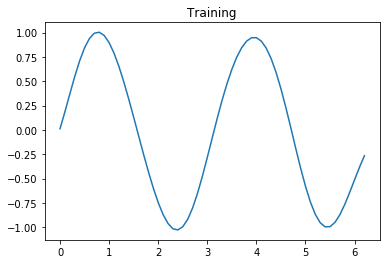

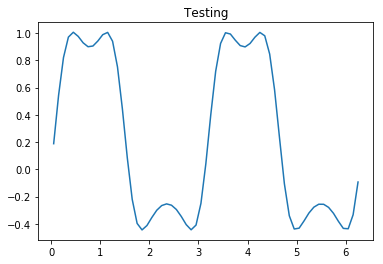

MSE Error: 0.0010264024993204455
ABS Error: 0.022582819906908184


In [177]:
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(lambda x:np.sin(x))
print(train_X.shape)
print(train_Y.shape)
centers = evenly_spaced_rbf(20)
network = RBF(centers, sigma=0.6, use_batch=False)
network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)

# Competitive Learning

In [203]:
def competitive_rbf(X,count,eta,iters, k_min = 1):
    np.random.shuffle(X)
    centers = X[0:count].copy() #initialize RBF to data
    
    for i in range(iters):
        train_vec = X[np.random.randint(0,len(X)),:] # get random vector
        distances = np.empty((0,0))
        for c in centers:
            distances = np.append(distances,(np.linalg.norm(c-train_vec)))
        

        idx = np.argpartition(distances, k_min)
        for j in idx[:k_min]:
            centers[j] += eta * (train_vec-centers[j])
    
    return centers

(63, 1)
(63, 1)


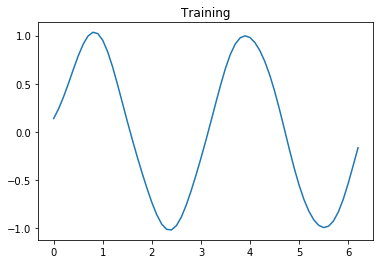

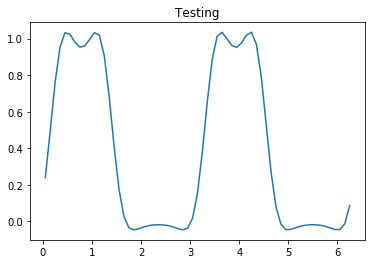

MSE Error: 0.0005607627647527135
ABS Error: 0.016436526956414742


In [204]:
train_X, train_Y, test_X, test_Y, clean_X, clean_Y = generate_data(lambda x:np.sin(x))
print(train_X.shape)
print(train_Y.shape)
centers = competitive_rbf(train_X.copy(),14,1,100)
network = RBF(centers, sigma=0.6)
network.train(train_X,train_Y,test_X,test_Y,eta=0.2, n_epochs=100)